## 캐글 leaderboard 프로젝트 
### exploration 9 나의 첫 번째 캐글 경진대회, 무작정 따라해보기


진행기간 (2021.02.02 ~ 2021.02.02)


참고사이트    
- https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12
- http://machinelearningkorea.com/2019/09/29/lightgbm-%ED%8C%8C%EB%9D%BC%EB%AF%B8%ED%84%B0/
- https://injo.tistory.com/48

# 결과


### 1. 튜닝 전 스코어 및 등수 (노드) : 120031 / 301등


### 2. 튜닝 후 스코어 및 등수 (노드) : 115688 / 216등


### 3. 박성준 XGboost 스코어 및 등수 :  116838 / 224등


### 4. 박성준 LGBM 스코어 및 등수 :  110367 / 105 등
- model = LGBMRegressor(learning_rate = 0.05, max_depth=10, num_iterations=1000, n_estimators=100,random_state=random_state)


# 후기

일단 무슨 말인지는 모르지만 파라미터만 변경해서 해본다.   
다음주 해커톤... 나 혼자 했으면....   
망쳐도 똥은 내가 치워야 할텐데..   ㅠㅠ      
어마어마한 나의 민폐가 예약되어 있어 탈모 올 것 같다!!!      
탈주닌자가 되고 싶다.

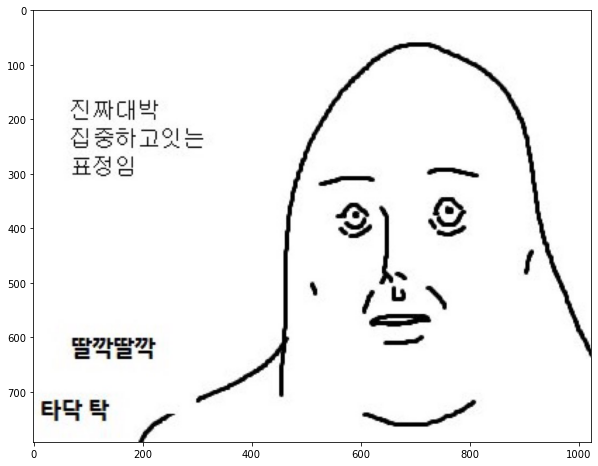

In [53]:
# 후기 요약 짤

import matplotlib.image as img
import matplotlib.pyplot as plt
import os

fileName = os.getenv('HOME') + "/aiffel/집중짤.jpg"
image = img.imread(fileName)
fig = plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

# 시작 전 고려해볼 사항

##  ✓ 튜닝해볼 수 있는 모델 클래스 인자
대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같습니다.

max_depth : 의사 결정 나무의 깊이, 정수 사용   
learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001와 0.1 사이의 실수 사용   
n_estimators : 사용하는 개별 모델의 개수, 보통 50과 100 이상의 정수 사용   
num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수   
boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력   --> 효과 없음
   

# 0. 필요한 모듈을 설치하자!

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 불러오기 및 EDA

In [31]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data' # 경로 지정

train_data_path = join(data_dir, 'train.csv') # 훈련데이터 경로
test_data_path = join(data_dir, 'test.csv')  # 테스트데이터 경로

train = pd.read_csv(train_data_path) # train이라는 변수에 훈련데이터 넣기
test = pd.read_csv(test_data_path) # test라는 변수에 테스트데이터 넣기

print("훈련데이터 :",train.shape)
print("테스트데이터 :",test.shape)

훈련데이터 : (15035, 21)
테스트데이터 : (6468, 20)


<AxesSubplot:>

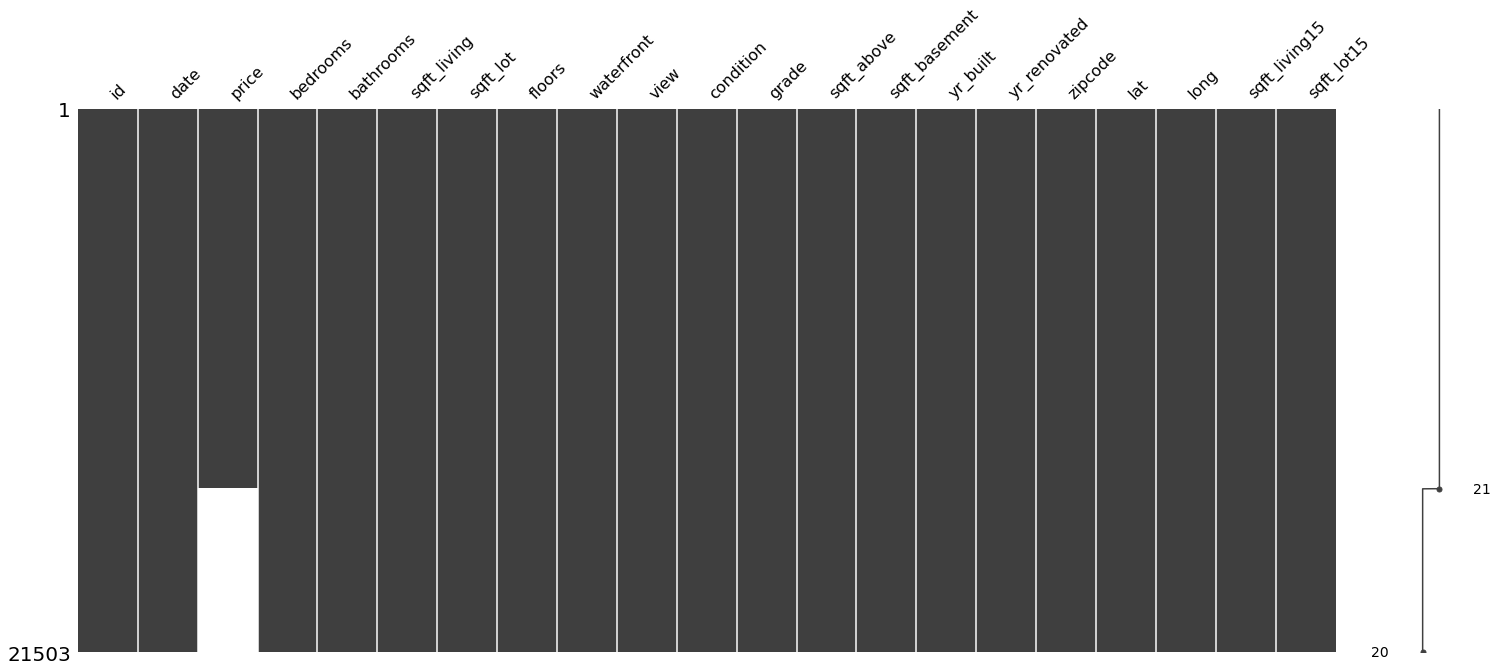

In [32]:
# 전체 결측치 확인!

data = pd.concat((train, test), axis=0)
msno.matrix(data) # test 데이터에 price가 없으니 price에 결측치가 보이는 것 나머지는 괜춘~

In [33]:
# 데이터를 확인해봅시다.

display(train.head())
print("----------------------------------------------------------")
display(test.head())

# ID : 집을 구분하는 번호
# date : 집을 구매한 날짜
# price : 집의 가격(Target variable)
# bedrooms : 침실의 수
# bathrooms : 화장실의 수
# sqft_living : 주거 공간의 평방 피트(면적)
# sqft_lot : 부지의 평방 피트(면적)
# floors : 집의 층 수
# waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
# view : Has been viewed
# condition : 집의 전반적인 상태
# grade : King County grading 시스템 기준으로 매긴 집의 등급
# sqft_above : 지하실을 제외한 평방 피트(면적)
# sqft_basement : 지하실의 평방 피트(면적)
# yr_built : 지어진 년도
# yr_renovated : 집을 재건축한 년도
# zipcode : 우편번호
# lat : 위도
# long : 경도
# sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
# sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)


# 정리하고 싶은 것 
# 1. id 인덱스를 없앤다.
# 2. date를 연월일 [:8]까지로 바꾼다.

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


----------------------------------------------------------


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [34]:
# id삭제와 date를 바꾸는 함수!

def EDA(sample):
    sample['date'] = sample['date'].apply(lambda i: i[:8]).astype(int) # float로 둘까?
    del sample['id']

In [35]:
EDA(train)
EDA(test)

display(train.head())
print(train.shape)
print("----------------------------------------------------------")
display(test.head())
print(test.shape)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


(15035, 20)
----------------------------------------------------------


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141209,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,20141209,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,20140512,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,20150415,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,20150312,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


(6468, 19)


In [36]:
# 여전히 컬럼 수에서 차이가 난다. ==> train에 price가 있으니까!!
# target으로 바꾸자.

y = train['price']
del train['price']

In [37]:
# 결국 우리가 알고 싶은 것은 y의 값이다!! y의 값의 분포를 알아봅시당
y.describe()

# 평균 : 5.406827e+05
# 표준편차 : 3.715247e+05
# 이상치 : Q1 - 1.5 * (Q3 - Q1) or Q3 + 1.5 * (Q3 - Q1)  ==> 1129500.0 이상이면 이상치이다.


count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

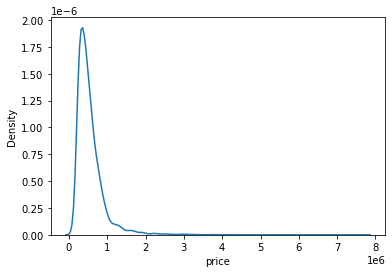

왜도 : 4.290252
첨도: 40.154919


In [38]:
# kdeplot으로 데이터의 분포를 봅시다. 

sns.kdeplot(y)
plt.show()

#skewness and kurtosis
print("왜도 : %f" % y.skew()) # 0보다 크면 좌측으로, 0보다 작으면 우측으로 쏠린 그래프
print("첨도: %f" % y.kurt()) # 3보다 크면 특정 값에 몰린 그래프

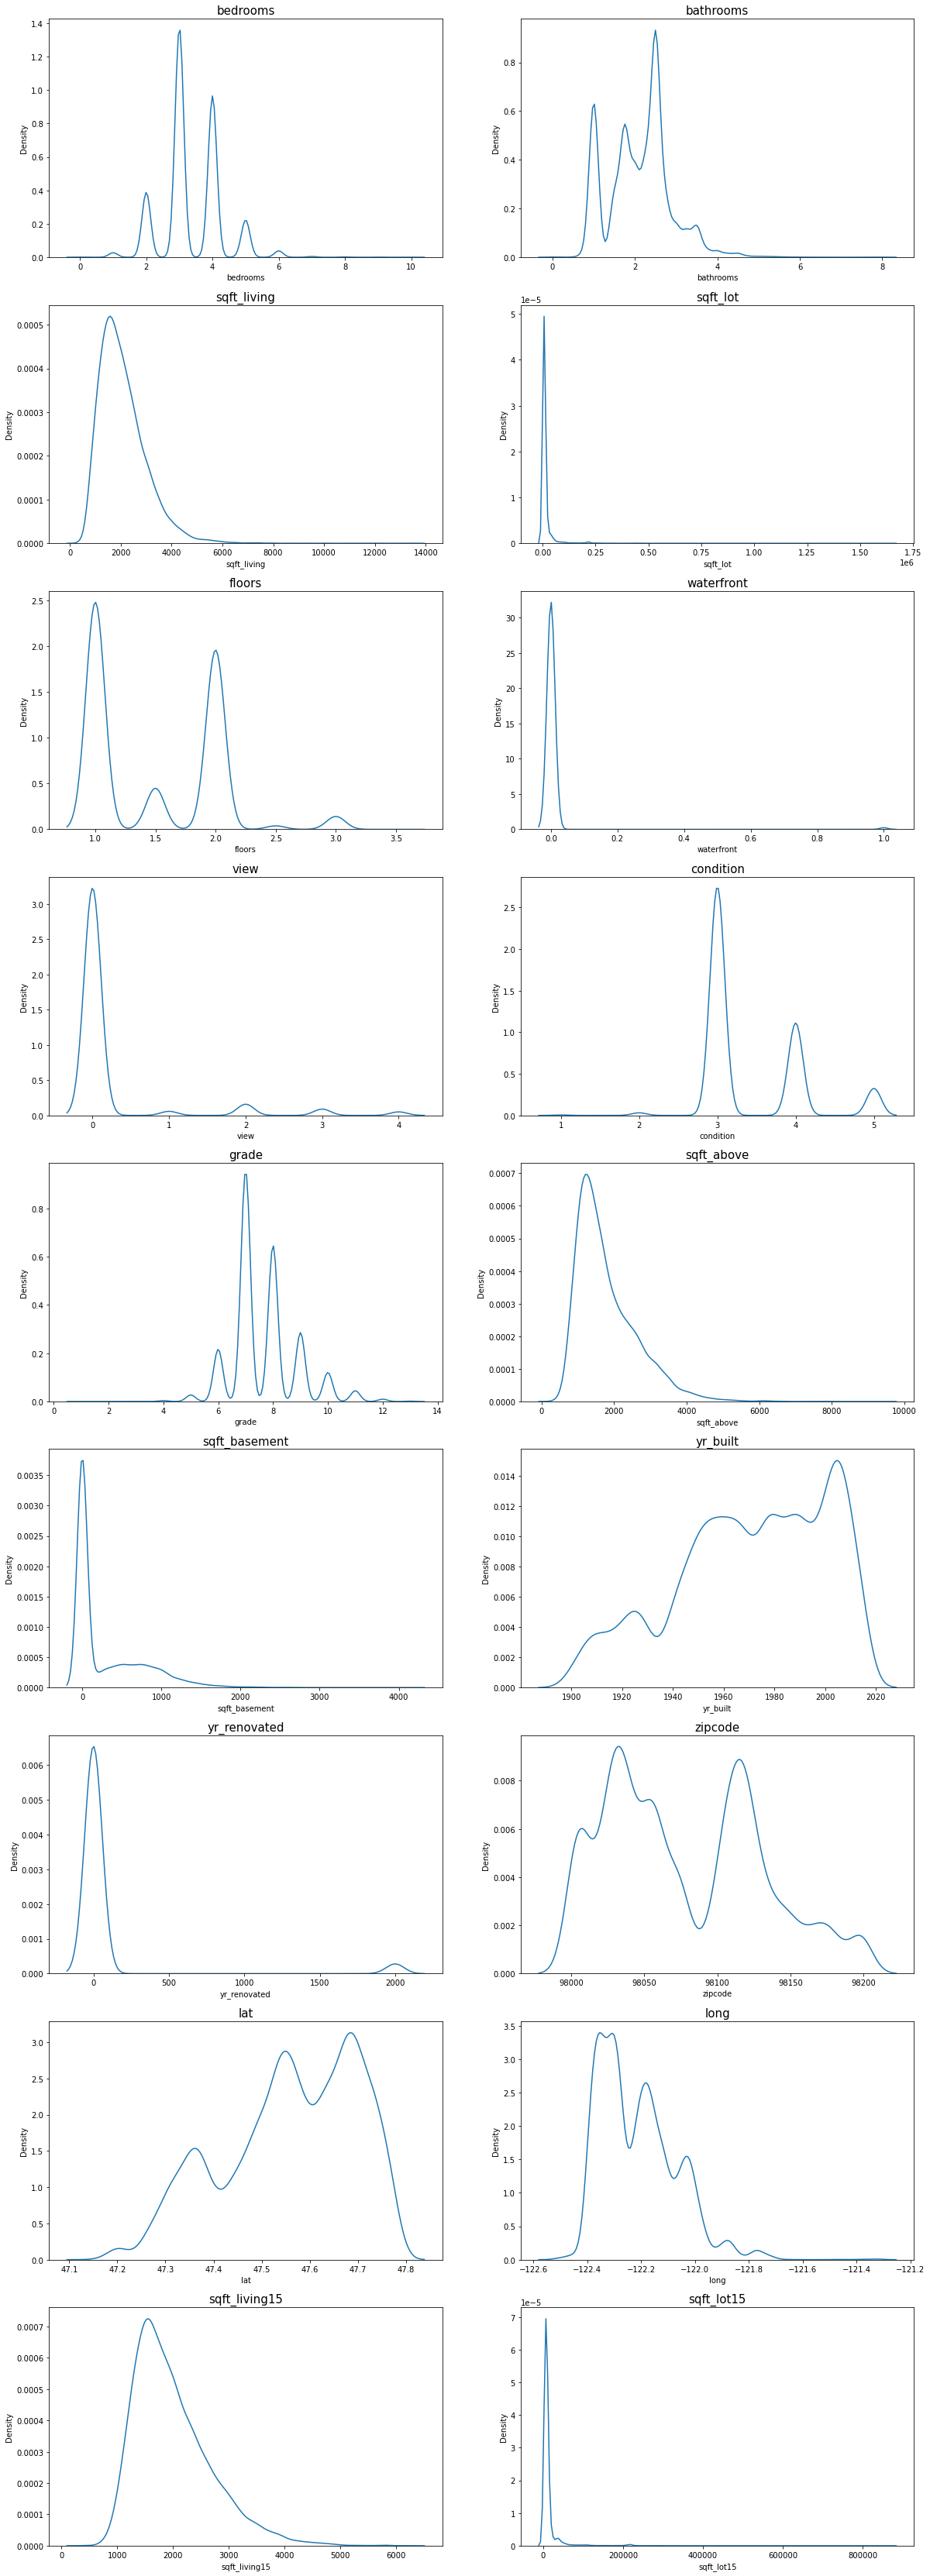

In [41]:
# train 데이터의 분포도 한번 봐봅시다.

fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# date 변수는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break

In [47]:
# train 데이터 컬럼들도 높은 왜도를 보입니다.
# 때문에 이를 자연로그로 정규화해야 합니당

skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)

In [48]:
display(train.head()) # 모두 정규화된 아름다운 상태

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013,0.869742,1.00,2.088663,2.265878,1.0,0,0,3,7,2.088663,0.0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225,0.741276,1.00,2.034403,2.323411,1.0,0,0,3,6,2.034403,0.0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218,0.869742,2.00,2.131458,2.302312,1.0,0,0,3,8,2.131458,0.0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627,0.869742,2.25,2.133900,2.285196,2.0,0,0,3,7,2.133900,0.0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115,0.869742,1.50,2.075304,2.320535,1.0,0,0,3,7,2.075304,0.0,1963,0,98198,47.4095,-122.315,1650,9711


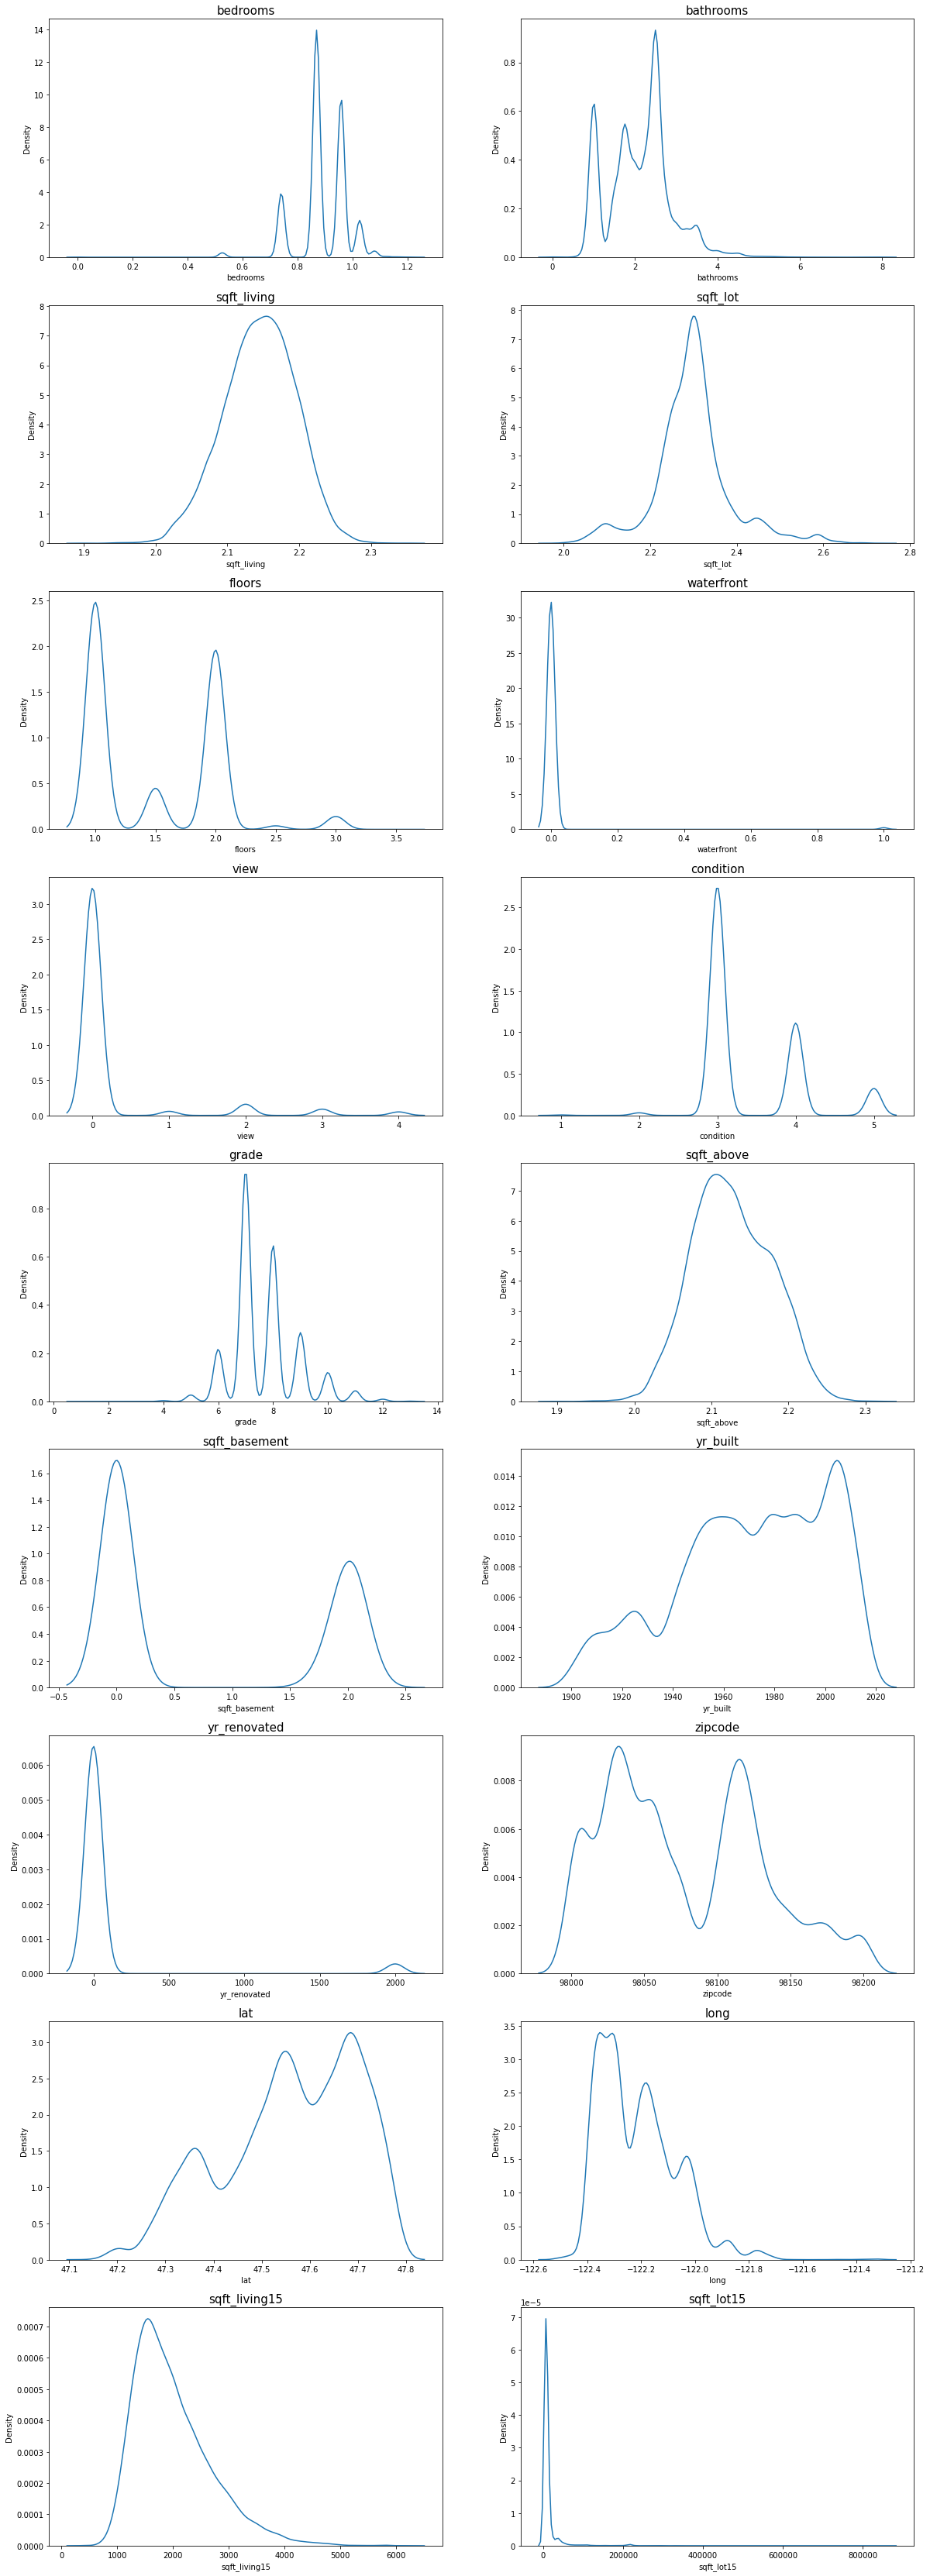

In [49]:
# train 데이터의 분포를 다시 한번 봐봅시다.

fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# date 변수는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count+=1
        if count == 19 :
            break
            
            
# 굳이 해줘야하나? 똑같은 거 같은데...?

In [50]:
print(train.shape)
print(test.shape)
# 둘 다 19개 컬럼인 것 확인

(15035, 19)
(6468, 19)


In [54]:
# 여러 가지 모델의 결과를 산술평균하여 블렌딩 모델을 만들겠습니다.
# 모델은 부스팅 계열인 gboost, xgboost, lightgbm 세 가지를 사용합니다.

gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [55]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(train.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train.values, y)), 
                                             kf=kfold))
        # 소수점 4자리까지 출력합니다. 모델의 이름과 모델 스코어, 데이터, 테스트데이터 등을 설정
        # kfold는 뭔지 모르겠ㄷ다.
        # get_n_split도 뭔지 모르겠다.

In [56]:
get_cv_score(models) # 교차검증을 통한 성능 출력!

Model GradientBoosting CV score : 0.8604
Model XGBoost CV score : 0.8836
Model LightGBM CV score : 0.8817


In [62]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y) # 모델을 훈련시킵니다.
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ]) # 예측을 column_stack은 아마 쌓는 것 같다. append와 같은 기능일 듯
    
    return np.mean(predictions, axis=1) # prediction의 평균을 낸다.

In [63]:
y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred)) # 테스트데이터 개수
y_pred # 예측값들의 나열! --> 적당한 실수값들인 것 같다.

6468


array([2020637.86712616, 1822228.9959691 , 2533156.18959665, ...,
       2172052.61681403, 1960313.90687981, 1429663.57337197])

# 여기서부터 코드를 고친다!!

# 2. 모델 튜닝에 들어가봅시다

In [3]:
# 데이터 가져오기
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

display(train.head())
display(test.head())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [4]:
# 날짜 컬럼 변경
train['date'] = train['date'].apply(lambda i: i[:8]).astype(int)

# 타겟데이터 생성 및 훈련데이터에서 price 삭제
y = train['price']
del train['price']

# 훈련데이터에서 id 삭제
del train['id']


# 테스트데이터에도 동일하게 진행
test['date'] = test['date'].apply(lambda i: i[:8]).astype(int)
del test['id']

In [5]:
# y 정규화
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [6]:
from sklearn.model_selection import train_test_split # 훈련데이터와 테스트데이터 나누기!
from sklearn.metrics import mean_squared_error # RMSE점수를 계산하는 함수!


In [7]:
# RMSE 값을 구하는 함수!! 먼저 log를 씌운 함수에 np.expml를 하고, 그 뒤 mean_squared_error 계산!!
# 이후 np.sqrt 계산합니당 --> np.sqrt는 제곱근 계산 함수입니당
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [8]:
# 모델은 XGBRegressor, LGBMRegressor, GradientBoostingRegressor, RandomForestRegressor 로
# 총 네 가지 모델을 가져오겠습니다.

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor # 여기에 2개!

In [9]:
# 아래와 같이 모델 인스턴스를 생성한 후 models라는 리스트에 넣어줍니다.

# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2021        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [10]:
# 모델값을 얻는 과정을 함수로 선언해보자.

def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
RandomForestRegressor,136973.133789
GradientBoostingRegressor,136310.553862
XGBRegressor,131075.327133
LGBMRegressor,128586.700332


In [11]:
from sklearn.model_selection import GridSearchCV

In [17]:
# Xgboost에 대한 파라미터를 입력합니다!
# 파라미터를 건드리자!!!
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
    'learning_rate' : [0.05,0.1],
    'num_iterations' : [1000,2000],
    'boosting_type': ['gblinear', 'gbtree', 'dart'] 
}

In [18]:
# 모델을 준비합니다! (LGBMRegressor)
model = LGBMRegressor(random_state=random_state)

In [19]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train, y)


# 여기에서 cross validation을 5번 진행하는 이유는, 
#각 조합에 대해 단 한 번만 실험을 하는 것보다 5번을 진행해서 평균을 취하는 것이 일반화 오차를 추정하는 데에 더 신뢰도가 높기 때문입니다. 
# 간단하게, 한 번만 해 보는 것보다는 다섯 번을 해보고 구한 평균값이 더 정확하겠죠!

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done 150 tasks      | elapsed:    0.5s
[Parallel(n_jobs=5)]: Done 240 out of 240 | elapsed:  6.4min finished


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2021), n_jobs=5,
             param_grid={'boosting_type': ['gblinear', 'gbtree', 'dart'],
                         'learning_rate': [0.05, 0.1], 'max_depth': [1, 10],
                         'n_estimators': [50, 100],
                         'num_iterations': [1000, 2000]},
             scoring='neg_mean_squared_error', verbose=1)

In [20]:
# 실험에 대한 결과는 다음과 같이 grid_model.cv_results_ 안에 저장됩니다.
grid_model.cv_results_

{'mean_fit_time': array([6.12778664e-03, 7.11078644e-03, 9.46760178e-03, 7.76638985e-03,
        7.23395348e-03, 6.56485558e-03, 6.74390793e-03, 7.94377327e-03,
        9.30843353e-03, 1.05351925e-02, 1.04180336e-02, 1.05569363e-02,
        1.03334904e-02, 1.16734505e-02, 1.20219231e-02, 1.05408192e-02,
        9.43279266e-03, 1.20627880e-02, 7.46431351e-03, 9.07130241e-03,
        8.88423920e-03, 7.03105927e-03, 5.54966927e-03, 7.41691589e-03,
        1.20013714e-02, 9.65662003e-03, 8.87031555e-03, 9.23604965e-03,
        1.15129471e-02, 1.09423637e-02, 9.72237587e-03, 8.29038620e-03,
        2.99933372e+00, 7.56747890e+00, 3.44214816e+00, 7.93295522e+00,
        1.95822970e+01, 3.83513089e+01, 1.14204029e+01, 3.30144301e+01,
        3.30753875e+00, 7.56928968e+00, 3.19482417e+00, 6.96643534e+00,
        1.91627715e+01, 3.04456061e+01, 1.92243546e+01, 3.98241573e+01]),
 'std_fit_time': array([5.47844173e-04, 1.09119265e-03, 1.53730210e-03, 1.37099527e-03,
        1.38434410e-03, 1.192

In [21]:
params = grid_model.cv_results_['params']
params

score = grid_model.cv_results_['mean_test_score']
score

array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, -0.10846186, -0.06960344, -0.10846186,
       -0.06960344, -0.07914755, -0.04872445, -0.07914755, -0.04872445,
       -0.05275557, -0.04480784, -0.05275557, -0.04480784, -0.03199219,
       -0.02914044, -0.03199219, -0.02914044])

In [22]:
# 최적의 하이퍼파라미터 조합을 찾아보자

results = pd.DataFrame(params)
results['score'] = score


,boosting_type,learning_rate,max_depth,n_estimators,num_iterations,score
0,gblinear,0.05,1,50,1000,NaN
1,gblinear,0.05,1,50,2000,NaN
2,gblinear,0.05,1,100,1000,NaN
3,gblinear,0.05,1,100,2000,NaN
4,gblinear,0.05,10,50,1000,NaN
5,gblinear,0.05,10,50,2000,NaN
6,gblinear,0.05,10,100,1000,NaN
7,gblinear,0.05,10,100,2000,NaN
8,gblinear,0.10,1,50,1000,NaN
9,gblinear,0.10,1,50,2000,NaN


In [23]:
results['RMSE'] = np.sqrt(-1 * results['score'])


,boosting_type,learning_rate,max_depth,n_estimators,num_iterations,score,RMSE
0,gblinear,0.05,1,50,1000,NaN,NaN
1,gblinear,0.05,1,50,2000,NaN,NaN
2,gblinear,0.05,1,100,1000,NaN,NaN
3,gblinear,0.05,1,100,2000,NaN,NaN
4,gblinear,0.05,10,50,1000,NaN,NaN
5,gblinear,0.05,10,50,2000,NaN,NaN
6,gblinear,0.05,10,100,1000,NaN,NaN
7,gblinear,0.05,10,100,2000,NaN,NaN
8,gblinear,0.10,1,50,1000,NaN,NaN
9,gblinear,0.10,1,50,2000,NaN,NaN


In [24]:
results = results.rename(columns={'RMSE': 'RMSLE'})


In [26]:
# 위의 표를 `RMSLE`가 낮은 순서대로 정렬해주세요.
results = results.sort_values('RMSLE')
results.head(10)

# 부스팅타입이 다트일 때, 러닝레이트가 0.1일때, max_depth이 10일 때, num_iterations이 2000일 때!!
## n_estimators는 큰 영향이 없는 것 같다. --> 이건 빼자
## dart 외에는 전부 NaN이다. dart만 넣자

,boosting_type,learning_rate,max_depth,n_estimators,num_iterations,score,RMSLE
45,dart,0.10,10,50,2000,-0.029140,0.170706
47,dart,0.10,10,100,2000,-0.029140,0.170706
44,dart,0.10,10,50,1000,-0.031992,0.178864
46,dart,0.10,10,100,1000,-0.031992,0.178864
41,dart,0.10,1,50,2000,-0.044808,0.211679
43,dart,0.10,1,100,2000,-0.044808,0.211679
37,dart,0.05,10,50,2000,-0.048724,0.220736
39,dart,0.05,10,100,2000,-0.048724,0.220736
40,dart,0.10,1,50,1000,-0.052756,0.229686
42,dart,0.10,1,100,1000,-0.052756,0.229686


In [27]:
# 위 과정을 함수로 만들어 여러 모델에 시험해봅시다.

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [57]:
# param_grid 설정!
# 위의 수정사항 반영
param_grid = {
    'max_depth': [1, 10],
    'n_estimators': [100],
    'learning_rate' : [0.01, 0.05,0.1],
    'num_iterations' : [1000,2000],
#     'boosting_type': ['rf','gbdt']  gbdt일 때 0.161737 나오지만, 없어도 그만큼 나온다.
}
# learning rate가 낮을 때 미묘하지만 더 낮게 나오긴 한다.

In [58]:
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5).head(10)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  3.9min
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:  8.6min finished


,learning_rate,max_depth,n_estimators,num_iterations,score,RMSLE
3,0.01,10,100,2000,-0.025977,0.161174
6,0.05,10,100,1000,-0.026159,0.161737
7,0.05,10,100,2000,-0.026586,0.163052
2,0.01,10,100,1000,-0.026751,0.163558
10,0.10,10,100,1000,-0.026916,0.164060
11,0.10,10,100,2000,-0.027492,0.165807
9,0.10,1,100,2000,-0.034308,0.185225
5,0.05,1,100,2000,-0.036472,0.190976
8,0.10,1,100,1000,-0.036514,0.191086
4,0.05,1,100,1000,-0.039053,0.197617


In [56]:
model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5).head(10)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:   23.7s
[Parallel(n_jobs=5)]: Done  80 out of  80 | elapsed:  1.1min finished


[17:19:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:541: 
Parameters: { boosting_type, num_iterations } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,boosting_type,learning_rate,max_depth,n_estimators,num_iterations,score,RMSLE
6,rf,0.10,10,100,1000,-0.027169,0.164831
7,rf,0.10,10,100,2000,-0.027169,0.164831
14,gbdt,0.10,10,100,1000,-0.027169,0.164831
15,gbdt,0.10,10,100,2000,-0.027169,0.164831
2,rf,0.05,10,100,1000,-0.035086,0.187314
3,rf,0.05,10,100,2000,-0.035086,0.187314
10,gbdt,0.05,10,100,1000,-0.035086,0.187314
11,gbdt,0.05,10,100,2000,-0.035086,0.187314
4,rf,0.10,1,100,1000,-0.054988,0.234496
5,rf,0.10,1,100,2000,-0.054988,0.234496


In [42]:
# 랜덤 XGBRegressor 결과가 더 좋다?! Nope!

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [52]:
model = LGBMRegressor(learning_rate = 0.05, max_depth=10, num_iterations=1000, n_estimators=100,random_state=random_state)

save_submission(model, train, y, test, 'lgbm', rmsle='0.0161')

/home/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0161.csv saved!
